In [1]:
#########################################################################
# Video Classification Tutorial - Using Inception v3 CNN + RNN & LSTM
# TensorFlow CPU + Keras 
#########################################################################


# GOAL - To understand the actions within a small video file (3-10 sec) 
# and then make a prediction of this video into various predefined classes. 


# DETAILS: The classes are embeded directly into the file name 
# and folder structure and will be substracted.

# From what I understand, we will first prepare the CNN by downloading 
# the Inceptionv3 pretrained algorithm (in TensorFlow and Keras) 
# and then add our specific video information into the top layer 
# of Inceptionv3 and retrain just that portion of the neural network.

# We will then flatten the results of the CNN and then feed the newly saved 
# features/weights into a Long Short Term Memory(LSTM) Recurrent Neural 
# Network (RNN) for further processing.

# What this code should do would be to take the video and split it into
# individual images via the cv2 package. For ease of use, we grab the 25th 
# frame of each video and then feed this into the the CNN.

# I think that the goal will be to seperate this code into at least 2 files
#      1. Training & Testing Procedure
#      2. Application of trained algorithm to new video


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# This is the video instructions of the author and coders work 
# (Gokhan Cagrici) which we are trying to replicate and recreate. 
# This is the most valuable resource that we have (and all that
# we have, unfortunately)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# https://www.youtube.com/watch?v=Txbfx47pYtg

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# This is the location of the data sources and background information:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# http://crcv.ucf.edu/data/UCF101.php#Results_on_UCF101
# http://www.thumos.info/download.html

In [2]:
# Declare Variables to be used later.

Raw_Video_Source = 'C:/Users/derek/Documents/Python_Scripts/Project_Adam/Raw_Video/'
Video_Frame_Destination = 'C:/Users/derek/Documents/Python_Scripts/Project_Adam/Raw_Video_Processed/'
Training_Sample = 0.95

base_dir = 'C:/Users/derek/Documents/Python_Scripts/Project_Adam/Raw_Video_Processed'

# This frame extract rate will pick up the Nth frame of a video.

frame_extract_rate = 25

# The shape of the individual image is 3 layers of 240 pixels by 320 pixels

horizontal_size = 240
vertical_size = 320
layer_count = 3


batch_size = 64 # Originally 64. 
model_batch_size = 64


label_count = 2 #Originally 3 - I think this is the # of classes

sample_multiple = 2 #This is used for the training procedure

Epochs_CNN = 4
Epochs_LSTM = 10

# This will place a hard cap of the total number of frames to N within a video clip.

video_frame_count = 80

# This will be a count of the videos for the RNN training

video_train_count = 10
video_test_count = 3


In [3]:
# Initialize Core Packages

import keras
import numpy as np
import matplotlib.pyplot as plt

import os

C:\Users\derek\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# Import the Inception 3 algorithm 

from keras.applications import InceptionV3

In [5]:
# We will re-train the top layer of Inception with our own dataset. Thats why we define include_top to false
# The shape of the individual image is 3 layers of 240 pixels by 320 pixels

conv_base = InceptionV3(weights='imagenet',
                       include_top=False,
                       input_shape=(horizontal_size, vertical_size, layer_count)
                       )

In [6]:
# Review the output parameters for the Inception v3

conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 320, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 119, 159, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 119, 159, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 119, 159, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [7]:
# Define a function that identifies all of the videos in a directory and creates a proper training and testing split.

def videos2frames(source_dir, target_dir, train_percentage):
    import os
    import re
    
    delete_dir(target_dir)
    create_dir_if_not_exists(target_dir)
    
    data_dirs = (f for f in sorted(os.listdir(source_dir)) if not f.startswith('.'))
                
    for cat_name in data_dirs:
        source_cat_dir = os.path.join(source_dir, cat_name)
        groups = list({re.search('^\w+_\w+_g(\d\d)_c(\d\d)', f).group(1) for f in os.listdir(source_cat_dir) if not f.startswith('.')})
        group_size = len(groups)
        np.random.shuffle(groups)
                 
        x = 0
        y = 0
        
        video_dir = os.path.join(source_dir, cat_name)
        
        video_path = (f for f in os.listdir(video_dir) if not f.startswith('.'))
        for video_file in video_path:
            m = re.search('^\w+_\w+_g(\d\d)_c(\d\d)', video_file)
            group_name = m.group(1)
            subject_name = m.group(2)
                 
            if group_name in groups[:int(group_size * train_percentage)]:
                parent_dir = 'train'
                x += 1
            else:
                parent_dir = 'test'
                y += 1
                 
            src_video_path = os.path.join(video_dir, video_file)
            frames_dir = os.path.join(os.path.join(target_dir, parent_dir),cat_name)
                 
            create_dir_if_not_exists(frames_dir)
            extract_frames_from_video(src_video_path, frames_dir, "{}-{}".format(group_name, subject_name))
                
def create_dir_if_not_exists(path):
    import os
    if not os.path.exists(path):
        os.makedirs(path)
                        
def delete_dir(path):
    import shutil
    import os
                 
    if os.path.exists(path):
        shutil.rmtree(path)

In [8]:
# Define a function that extracts the frames from a video.

def extract_frames_from_video(video_path, target_dir, target_file_prefix):
    import cv2
    
    v = cv2.VideoCapture(video_path)
    
    success, image = v.read()
    count = 0 
    
    while success:
        count += 1
        if count % frame_extract_rate == 0:
            cv2.imwrite('{}/{}-{}.jpg'.format(target_dir, target_file_prefix, count), image)
        success, image = v.read()

In [9]:
# This is the funciton which creates the training/test split and also extracts out individual pictures

videos2frames(Raw_Video_Source, Video_Frame_Destination, Training_Sample) 

In [10]:
# Define the training and validation directories for later.

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

In [11]:
# This component will rescale the images to fall in the 255 numeric range 

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

In [12]:
# This function is a count of the total number of features

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 6, 8, 2048))
    labels = np.zeros(shape=(sample_count, label_count)) 
    generator = datagen.flow_from_directory(
        directory,
        target_size=(horizontal_size, vertical_size),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        print(i * batch_size)
        if i * batch_size >= sample_count:
            break
    return features, labels 

In [13]:
%%capture output

generator = datagen.flow_from_directory(validation_dir, 
                                        target_size=(horizontal_size, vertical_size), 
                                        batch_size=batch_size, 
                                        class_mode='categorical')


In [14]:
# This pulls out programatically the total number of images to be used at a later time.

prev_cell_output = str(output)

# This finds the nth word of a string

image_number = int(prev_cell_output.split()[1])

In [15]:
# These steps will be removed later. Used for now until we can define the parameter
 
batch_size = image_number 
batch_size_validate = image_number

In [16]:
# This will run the validation routine and begin to train the features. Sample size is a multiple of the batch

validation_features, validation_labels = extract_features(validation_dir, batch_size*sample_multiple) # Original 237, batch size times 2 ensures no errors.

Found 45 images belonging to 2 classes.
45
90


In [17]:
# This will save the validation routine's features and labels.

np.save("validation_features.npy", validation_features)
np.save("validation_labels.npy", validation_labels)

validation_features.shape, validation_labels.shape

((90, 6, 8, 2048), (90, 2))

In [18]:
%%capture output2

generator_train = datagen.flow_from_directory(train_dir, 
                                              target_size=(horizontal_size, vertical_size), 
                                              batch_size=batch_size, 
                                              class_mode='categorical')

In [19]:
# This pulls out programatically the total number of images to be used at a later time.

prev_cell_output2 = str(output2)

# This finds the nth word of a string

image_number2 = int(prev_cell_output2.split()[1])

In [20]:
# This is where we will export the # of images above  to a dynamic value

batch_size = image_number2 
batch_size_train = image_number2

In [21]:
# This will run the training routine and begin to train the features. Sample size is a multiple of the batch

train_features, train_labels = extract_features(train_dir, batch_size*sample_multiple) # Original 3104, batch size times 2 ensures no errors.

Found 149 images belonging to 2 classes.
149
298


In [22]:
# This will save the training routine's features and labels.

np.save("train_features.npy", train_features)
np.save("train_labels.npy", train_labels)

train_features.shape, train_labels.shape

((298, 6, 8, 2048), (298, 2))

In [23]:
# Setup of the train features and validation features 

train_features = np.reshape(train_features, (batch_size_train*sample_multiple, 6 * 8 * 2048)) # Original 3104 
validation_features = np.reshape(validation_features, (batch_size_validate*sample_multiple, 6 * 8 * 2048)) # Original 237

In [24]:
# add layers to the existing Inception model

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=6 * 8 * 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(label_count, activation='softmax')) # Original is 3

model.compile(optimizer=optimizers.adam(lr=2e-6),
             loss='categorical_crossentropy',
             metrics=['acc'])

history = model.fit(train_features, train_labels,
                   epochs=Epochs_CNN, 
                   batch_size=model_batch_size,
                   validation_data=(validation_features, validation_labels))

Train on 298 samples, validate on 90 samples
Epoch 1/4
298/298 [==============================] - 6s 20ms/step - loss: 0.9515 - acc: 0.5369 - val_loss: 0.5819 - val_acc: 0.7333
Epoch 2/4
298/298 [==============================] - 3s 10ms/step - loss: 0.3686 - acc: 0.8221 - val_loss: 0.4399 - val_acc: 0.8444
Epoch 3/4
298/298 [==============================] - 3s 9ms/step - loss: 0.2032 - acc: 0.9430 - val_loss: 0.3491 - val_acc: 0.9111
Epoch 4/4
298/298 [==============================] - 3s 10ms/step - loss: 0.1116 - acc: 0.9631 - val_loss: 0.2883 - val_acc: 0.9333


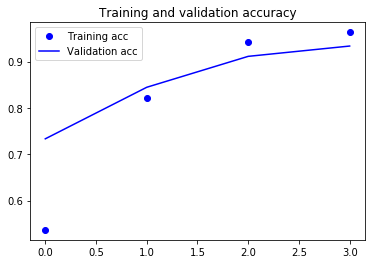

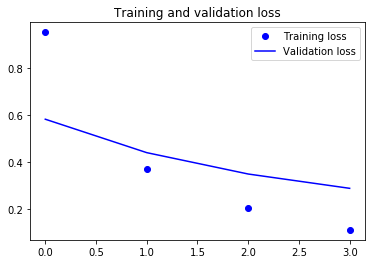

<Figure size 432x288 with 0 Axes>

In [25]:
# Diagnostic plots for the CNN algorithm accuracy

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.show()

In [26]:
# Save the Newly Trained Inception Model

model.save('inception3.h5')

In [27]:
#Check the directories

train_dir, validation_dir

('C:/Users/derek/Documents/Python_Scripts/Project_Adam/Raw_Video_Processed\\train',
 'C:/Users/derek/Documents/Python_Scripts/Project_Adam/Raw_Video_Processed\\test')

In [28]:
# Find the category group names

def find_cat_groups(dir_name):
    import re
    
    cat_groups = {}
    
    for cat in os.listdir(dir_name):
        samples_dir = os.path.join(dir_name, cat)
        cat_groups[cat] = {re.search('^(\d+)', f).group(1) for f in os.listdir(samples_dir) if not f.startswith('.')}
    
    return cat_groups

In [29]:
# Additional features to review

cat_groups_train, cat_groups_validation = find_cat_groups(train_dir), find_cat_groups(validation_dir)

In [30]:
#Display the catgory of training

cat_groups_train

{'HorseRace': {'02', '03'}, 'HorseRiding': {'02', '03', '04'}}

In [31]:
# Display the catgory of validation

cat_groups_validation

{'HorseRace': {'01'}, 'HorseRiding': {'01'}}

In [32]:
# Ensure that the length of the train and validation are identical

len(cat_groups_train), len(cat_groups_validation)

(2, 2)

In [33]:
# Review the categories in a dictionary that you train

cat_dict = {cat_name: i for i, cat_name in enumerate(cat_groups_train.keys())}

In [34]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=6 * 8 * 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(label_count, activation='softmax'))

In [35]:
print('HorseRace', cat_dict['HorseRace'])

HorseRace 0


In [36]:
# model.load_weights('inception3.h5')

In [37]:
# Display the inception 3 model with the top layer retrained to ensure that everything is working

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               25166080  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 25,166,594
Trainable params: 25,166,594
Non-trainable params: 0
_________________________________________________________________


In [38]:
# This is the addition of flattening layers to the CNN.

from keras import models
from keras import layers

model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(model.layers[0])

In [39]:
# This is the second models summary.

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 8, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               25166080  
Total params: 46,968,864
Trainable params: 46,934,432
Non-trainable params: 34,432
_________________________________________________________________


In [40]:
def extract_features_RNN(cat_dict, dir_path, cat_groups, sample_size):
    import re
    import cv2
    
    s = 0
    
    features = np.zeros(shape=(sample_size, 80 , 256))
    labels = np.zeros(shape=(sample_size, layer_count)) # original 3 label_count
    frames = np.zeros(shape=(80, horizontal_size, vertical_size, layer_count)) # original 3
    
    video_path = (f for f in os.listdir(dir_path) if not f.startswith('.'))
    for cat in video_path:
        print(cat, cat_dict[cat])
        cat_dir = os.path.join(dir_path, cat)
        video_files = (f for f in os.listdir(cat_dir) if not f.startswith('.'))
        for f in video_files:
        #for f in sorted(video_files)[1:]:
            if s >= sample_size:
                break
            group_name = re.search('^\w+_\w+_g(\d\d)', f).group(1)
            if group_name in cat_groups[cat]:
                v = cv2.VideoCapture(os.path.join(cat_dir, f))
                frame_count = int(v.get(cv2.CAP_PROP_FRAME_COUNT))
                frame_height = int(v.get(cv2.CAP_PROP_FRAME_HEIGHT))
                frame_width = int(v.get(cv2.CAP_PROP_FRAME_WIDTH))
                if frame_count >= video_frame_count and frame_height == horizontal_size and frame_width == vertical_size:
                    read_frames_idx = list(range(0, frame_count, frame_count))
                    for i, idx in enumerate(read_frames_idx):
                        v.set(cv2.CAP_PROP_POS_FRAMES, idx)
                        success, image = v.read()
                            #print(s, i, idx, success)
                        if success:
                            frames[i] = image / 255.
                        else:
                            print("ERROR")
                    features[s, :, :] = model2.predict(frames)
                    labels[s, cat_dict[cat]] = 1
                    print(s)
                    s += 1
                        
    return s, features, labels

In [41]:
# This is the RNN training procedure

size, features_rnn, labels_rnn = extract_features_RNN(cat_dict, Raw_Video_Source, cat_groups_train, video_train_count) # original 3104


HorseRace 0
0
1
2
3
4
5
6
7
HorseRiding 1
8
9


In [42]:
# Save the various features for the RNN training

np.save("features_rnn", features_rnn[:size,:,:])
np.save("labels_rnn", labels_rnn[:size,:])
size

10

In [43]:
# This is the RNN validation procedure

size_v, features_rnn_v, labels_rnn_v = extract_features_RNN(cat_dict, Raw_Video_Source, cat_groups_validation, video_test_count) #original is 237

HorseRace 0
0
1
2
HorseRiding 1


In [44]:
# Save the various features for the RNN training

np.save("features_rnn_v.np", features_rnn_v[:size_v,:,:])
np.save("labels_rnn_v.np", labels_rnn_v[:size_v,:])

In [45]:
# Describe the various features

features_rnn.shape, labels_rnn.shape

((10, 80, 256), (10, 3))

In [46]:
# Describe the RNN various features for the validation

features_rnn_v.shape, labels_rnn_v.shape

((3, 80, 256), (3, 3))

In [47]:
# This finds the first value of a tuple

Dense_Function = labels_rnn_v.shape[1]

In [48]:
# This code adds the LSTM into the inception model training

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(200, input_shape=(video_frame_count, 256)))
model.add(Dense(Dense_Function, activation='softmax')) # Original 3

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['acc'])

In [49]:
# Train the LSTM algorithm

hist = model.fit(features_rnn, labels_rnn,
                epochs=Epochs_LSTM, # 30 in the original
                batch_size=64,
                validation_data=(features_rnn_v, labels_rnn_v))

Train on 10 samples, validate on 3 samples
Epoch 1/10
10/10 [==============================] - 3s 322ms/step - loss: 1.1195 - acc: 0.0000e+00 - val_loss: 0.5101 - val_acc: 1.0000
Epoch 2/10
10/10 [==============================] - 0s 11ms/step - loss: 0.7060 - acc: 0.8000 - val_loss: 0.1870 - val_acc: 1.0000
Epoch 3/10
10/10 [==============================] - 0s 11ms/step - loss: 0.5487 - acc: 0.8000 - val_loss: 0.1319 - val_acc: 1.0000
Epoch 4/10
10/10 [==============================] - 0s 11ms/step - loss: 0.5383 - acc: 0.8000 - val_loss: 0.1673 - val_acc: 1.0000
Epoch 5/10
10/10 [==============================] - 0s 11ms/step - loss: 0.5121 - acc: 0.8000 - val_loss: 0.2575 - val_acc: 1.0000
Epoch 6/10
10/10 [==============================] - 0s 12ms/step - loss: 0.5040 - acc: 0.8000 - val_loss: 0.3199 - val_acc: 1.0000
Epoch 7/10
10/10 [==============================] - 0s 13ms/step - loss: 0.5157 - acc: 0.8000 - val_loss: 0.2732 - val_acc: 1.0000
Epoch 8/10
10/10 [=================

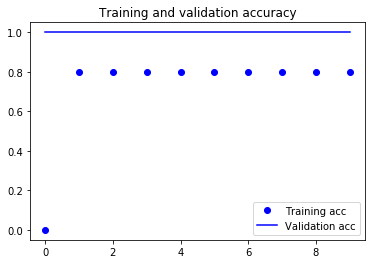

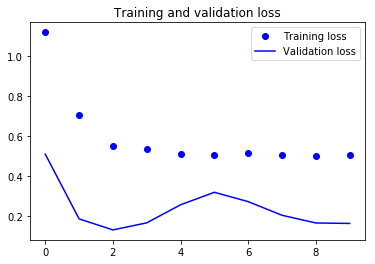

<Figure size 432x288 with 0 Axes>

In [50]:
# Diagnostic plots for the CNN algorithm accuracy

acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.show()

In [51]:
# Save the Newly Trained LSTM Model & Inception

model.save('inception3LSTM.h5')

In [52]:
###################################################################################################
# This is the model loading routine and scoring of a new video
###################################################################################################

In [53]:
# https://github.com/harvitronix/continuous-online-video-classification-blog/blob/master/online.py

In [54]:
# This is how we load the saved features

# validation_features = np.load("validation_features.npy")
# validation_labels = np.load("validation_labels.npy")
# train_features = np.load("train_features.npy")
# train_labels = np.load("train_labels.npy")

In [55]:
# model.load_weights('inception3.h5')

In [56]:
# features_rnn = np.load("features_rnn.np.npy")
# labels_rnn = np.load("labels_rnn.np.npy")

In [57]:
# features_rnn_v = np.load("features_rnn_v.np.npy")
# labels_rnn_v = np.load("labels_rnn_v.np.npy")